# Visualize embeddings

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from dawnet.inspector import LLMInspector
from dawnet.tokens import Tokens
from dawnet import op

torch.set_grad_enabled(False)

In [2]:
model_id = "openai-community/gpt2"
insp = LLMInspector.from_hf(model_id)

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: openai-community/gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [3]:
insp.model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Check the King-Queen common use case

The embeddings from LLM don't have the same mathematical formulation as word2vec.

In [6]:
embed_layer = insp.model.model.embed_tokens

In [7]:
king, queen = " king", " queen"
man, woman = " man", " woman"

In [8]:
king_emb = embed_layer(insp.tokenizer.encode(king, return_tensors="pt").to(device)).squeeze()
queen_emb = embed_layer(insp.tokenizer.encode(queen, return_tensors="pt").to(device)).squeeze()
man_emb = embed_layer(insp.tokenizer.encode(man, return_tensors="pt").to(device)).squeeze()
woman_emb = embed_layer(insp.tokenizer.encode(woman, return_tensors="pt").to(device)).squeeze()

In [9]:
print(f"{king_emb=}")
print(f"{queen_emb=}")
print(f"{man_emb=}")
print(f"{woman_emb=}")

king_emb=tensor([-5.7373e-02, -4.6015e-05,  1.8433e-02,  ..., -2.8442e-02,
        -2.6001e-02,  8.9111e-03], device='mps:0')
queen_emb=tensor([-0.0435, -0.0014, -0.0068,  ...,  0.0039, -0.0130, -0.0022],
       device='mps:0')
man_emb=tensor([ 0.0135, -0.0410,  0.0153,  ...,  0.0014,  0.0022,  0.0154],
       device='mps:0')
woman_emb=tensor([ 0.0317, -0.0330, -0.0248,  ..., -0.0273, -0.0093, -0.0220],
       device='mps:0')


In [10]:
king_emb - queen_emb

tensor([-0.0139,  0.0014,  0.0252,  ..., -0.0323, -0.0130,  0.0112],
       device='mps:0')

In [11]:
man_emb - woman_emb

tensor([-0.0182, -0.0081,  0.0401,  ...,  0.0287,  0.0114,  0.0374],
       device='mps:0')

In [12]:
man_emb - woman_emb + queen_emb

tensor([-0.0616, -0.0095,  0.0333,  ...,  0.0326, -0.0016,  0.0351],
       device='mps:0')

In [13]:
king_emb

tensor([-5.7373e-02, -4.6015e-05,  1.8433e-02,  ..., -2.8442e-02,
        -2.6001e-02,  8.9111e-03], device='mps:0')

In [14]:
F.cosine_similarity(king_emb, queen_emb, dim=0)

tensor(0.3412, device='mps:0')

In [15]:
F.cosine_similarity(man_emb, woman_emb, dim=0)

tensor(0.3838, device='mps:0')

In [16]:
F.cosine_similarity(king_emb, man_emb - woman_emb + queen_emb, dim=0)

tensor(0.2744, device='mps:0')

In [17]:
((king_emb - woman_emb)**2).sum()

tensor(1.3488, device='mps:0')

In [18]:
((king_emb - (man_emb - woman_emb + queen_emb))**2).sum()

tensor(1.7163, device='mps:0')

In [19]:
def cosine_similarity_between_words(word1, word2):
    word1_embed = embed_layer(insp.tokenizer.encode(word1, return_tensors="pt").to(device)).squeeze()
    word2_embed = embed_layer(insp.tokenizer.encode(word2, return_tensors="pt").to(device)).squeeze()
    cosine_simlarity = F.cosine_similarity(word1_embed, word2_embed, dim=0).cpu().item()
    l2_dist = ((word1_embed - word2_embed)**2).sum().cpu().item()
    print(f"{word1}-{word2}:", 'cos:', round(cosine_simlarity, 3), 'l2 dist:', round(l2_dist, 3))

In [60]:
cosine_similarity_between_words("king", " king")

king- king: cos: 0.569 l2 dist: 1.118


In [61]:
cosine_similarity_between_words("king", " queen")

king- queen: cos: 0.328 l2 dist: 1.719


In [62]:
cosine_similarity_between_words("king", "queen")

king-queen: cos: 0.282 l2 dist: 1.963


In [63]:
cosine_similarity_between_words("king", " man")

king- man: cos: -0.001 l2 dist: 2.61


In [64]:
cosine_similarity_between_words("king", "man")

king-man: cos: 0.032 l2 dist: 2.528


In [65]:
cosine_similarity_between_words(" king", " man")

 king- man: cos: 0.072 l2 dist: 2.064


In [20]:
cosine_similarity_between_words("king", " king")

king- king: cos: 0.373 l2 dist: 1.016


In [21]:
cosine_similarity_between_words("king", " queen")

king- queen: cos: 0.168 l2 dist: 1.473


In [23]:
cosine_similarity_between_words("king", "queen")

king-queen: cos: 0.196 l2 dist: 1.457


In [27]:
cosine_similarity_between_words(" king", " man")

 king- man: cos: 0.114 l2 dist: 1.202


In [26]:
cosine_similarity_between_words("king", "man")

king-man: cos: 0.072 l2 dist: 1.369


In [29]:
F.cosine_similarity(king_emb, man_emb, dim=0)

tensor(0.1137, device='mps:0')

In [28]:
F.cosine_similarity(king_emb, man_emb - woman_emb + queen_emb, dim=0)

tensor(0.2744, device='mps:0')

In [30]:
F.cosine_similarity(king_emb, man_emb + queen_emb, dim=0)

tensor(0.3233, device='mps:0')

In [35]:
F.cosine_similarity(man_emb, (man_emb+woman_emb), dim=0)

tensor(0.8150, device='mps:0')

In [36]:
F.cosine_similarity(king_emb, man_emb + woman_emb, dim=0)

tensor(0.1178, device='mps:0')

In [37]:
F.cosine_similarity(king_emb, queen_emb, dim=0)

tensor(0.3412, device='mps:0')

In [38]:
cosine_similarity_between_words(" king", " queen")

 king- queen: cos: 0.341 l2 dist: 1.098


In [39]:
cosine_similarity_between_words(" man", " woman")

 man- woman: cos: 0.384 l2 dist: 0.812


In [52]:
cosine_similarity_between_words(" Paris", " king")

 Paris- king: cos: 0.039 l2 dist: 1.793


In [53]:
cosine_similarity_between_words(" London", " king")

 London- king: cos: 0.057 l2 dist: 1.661


### Check embedding from different models

In [54]:
model_id2 = "Qwen/Qwen3-4B-Thinking-2507"
insp2 = LLMInspector.from_hf(model_id2).to(device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
insp2.model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [59]:
embed_layer2 = insp2.model.model.embed_tokens

In [60]:
def cosine_similarity_between_words2(word1, word2):
    word1_embed = embed_layer2(insp2.tokenizer.encode(word1, return_tensors="pt").to(device)).squeeze()
    word2_embed = embed_layer2(insp2.tokenizer.encode(word2, return_tensors="pt").to(device)).squeeze()
    cosine_simlarity = F.cosine_similarity(word1_embed, word2_embed, dim=0).cpu().item()
    l2_dist = ((word1_embed - word2_embed)**2).sum().cpu().item()
    print(f"{word1}-{word2}:", 'cos:', round(cosine_simlarity, 3), 'l2 dist:', round(l2_dist, 3))

In [61]:
cosine_similarity_between_words2(" king", " queen")

 king- queen: cos: 0.556 l2 dist: 0.959


In [62]:
cosine_similarity_between_words2(" man", " woman")

 man- woman: cos: 0.327 l2 dist: 1.364


In [63]:
cosine_similarity_between_words2(" Paris", " king")

 Paris- king: cos: 0.043 l2 dist: 1.984


In [65]:
cosine_similarity_between_words2(" London", " king")

 London- king: cos: 0.051 l2 dist: 1.878


## Visualize embeddings

### With PCA

In [4]:
categories = ["boy_first_names", "girl_first_names", "countries", "capitals", "colors", "months", "emotions", "action_verbs", "occupations"]
word_lists = {
    "boy_first_names": [
        "James", "John", "Michael", "David", "Daniel",
        "Matthew", "Andrew", "Thomas", "Mark", "Paul",
        "Peter", "Kevin", "Brian"
    ],
    
    "girl_first_names": [
        "Mary", "Sarah", "Emma", "Emily", "Jessica",
        "Anna", "Laura", "Lisa", "Jennifer", "Karen",
        "Amy", "Rachel", "Susan"
    ],
    
    "countries": [
        "France", "Spain", "Italy", "Japan", "China",
        "Brazil", "Canada", "Mexico", "India", "Egypt",
        "Greece", "Turkey", "Peru"
    ],
    
    "capitals": [
        "Paris", "London", "Rome", "Tokyo", "Berlin",
        "Madrid", "Ottawa", "Cairo", "Athens", "Moscow",
        "Beijing", "Delhi", "Lima"
    ],
    
    "colors": [
        "red", "blue", "green", "yellow", "orange",
        "purple", "pink", "brown", "black", "white",
        "gray", "silver", "gold"
    ],
    
    "months": [
        "January", "February", "March", "April", "May",
        "June", "July", "August", "September", "October",
        "November", "December"
    ],
    
    "emotions": [
        "happy", "sad", "angry", "excited", "scared",
        "surprised", "confused", "proud", "worried", "calm",
        "nervous", "grateful", "lonely"
    ],
    
    "action_verbs": [
        "run", "jump", "walk", "swim", "dance",
        "sing", "eat", "sleep", "read", "write",
        "play", "talk", "laugh"
    ],

    "occupations": [
        "teacher", "doctor", "nurse", "chef", "pilot",
        "farmer", "artist", "writer", "lawyer", "engineer",
        "dentist", "police", "firefighter"
    ]
}

In [5]:
embed_layer = insp.model.model.language_model.embed_tokens

In [6]:
embeddings = {}
for cat, wl in word_lists.items():
    we = {}
    for w in wl:
        _emb = embed_layer(insp.tokenizer.encode(f' {w}', return_tensors="pt").to(device)[:,-1:]).cpu().squeeze()
        if len(_emb.shape) > 1:
            print(w, _emb.shape)
            continue
        we[w] = _emb
    embeddings[cat] = we

n_embeddings = sum([len(v) for v in embeddings.values()])
print(f"There are {n_embeddings} vectors")

There are 116 vectors


In [7]:
embeddings['capitals']

{'Paris': tensor([ 1.2083, -0.0066, -1.2351,  ...,  0.7608, -1.3515,  0.0515]),
 'London': tensor([ 2.1481, -0.4072, -2.1391,  ..., -1.0830, -1.0561, -0.8413]),
 'Rome': tensor([-0.2808, -0.8995, -0.9353,  ..., -0.0400, -0.6444,  0.1113]),
 'Tokyo': tensor([-0.5639, -1.6648,  0.0200,  ...,  1.1412, -1.0114, -0.2629]),
 'Berlin': tensor([ 0.3983,  0.0260, -0.9264,  ...,  1.8527, -2.7925,  0.4721]),
 'Madrid': tensor([ 0.4744,  0.7921, -1.1322,  ..., -0.1432, -1.7901, -0.8771]),
 'Ottawa': tensor([-1.6737, -0.0025, -0.8950,  ...,  1.3247, -0.2976,  0.2461]),
 'Cairo': tensor([ 0.6713, -0.5639, -2.0586,  ...,  0.6176, -1.2172, -0.5997]),
 'Athens': tensor([ 1.7722,  0.4967, -0.5818,  ...,  0.6713, -0.6758,  0.0962]),
 'Moscow': tensor([ 0.0895, -1.5216, -1.3694,  ..., -0.6937, -1.3515, -0.1723]),
 'Beijing': tensor([ 1.3963, -2.3271, -0.5057,  ...,  0.6981, -0.4654,  0.8727]),
 'Delhi': tensor([ 0.3893, -0.2954, -1.4858,  ...,  1.1993, -0.1152, -1.3157]),
 'Lima': tensor([ 2.7209,  0.9666

In [8]:
embedding_np = []
for v in embeddings.values():
    for e in v.values():
        embedding_np.append(e)

In [9]:
embedding_classes = []
legends = {}
for idx, (k,v) in enumerate(embeddings.items()):
    legends[idx+1] = k
    embedding_classes += [k] * len(v)

In [10]:
embedding_np = torch.stack(embedding_np, dim=0).float().numpy()
embedding_np.shape

(116, 5376)

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [12]:
SS = StandardScaler()
X = SS.fit_transform(embedding_np)
X.shape

(116, 5376)

In [13]:
print(f"{embedding_np.mean()=}, {embedding_np.std()=}")
print(f"{X.mean()=}, {X.std()=}")

embedding_np.mean()=-0.00042790434, embedding_np.std()=1.0371522
X.mean()=3.6702366e-10, X.std()=1.0


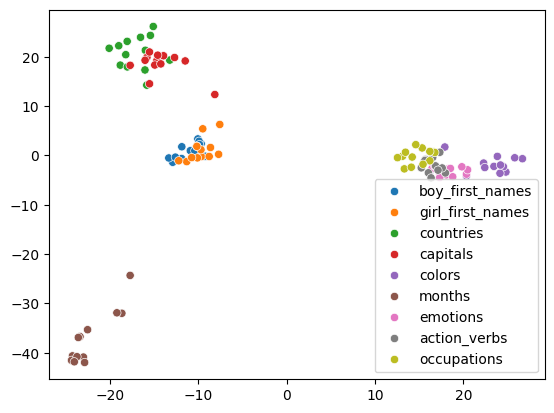

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
fig = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=embedding_classes)

In [84]:
type(fig)

matplotlib.axes._axes.Axes

In [15]:
fig = fig.get_figure()
fig.savefig("gemma-3-27b-it_emb.png")

In [19]:
import plotly.express as px
import numpy as np

In [20]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

In [21]:
fig = px.scatter_3d(
    X_pca3, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)

fig.show()

In [22]:
print(f"{pca.explained_variance_ratio_=}")
print(f"{pca3.explained_variance_ratio_=}")

pca.explained_variance_ratio_=array([0.04116973, 0.03895879], dtype=float32)
pca3.explained_variance_ratio_=array([0.04116974, 0.03895883, 0.03175575], dtype=float32)


### With t-SNE

<Axes: >

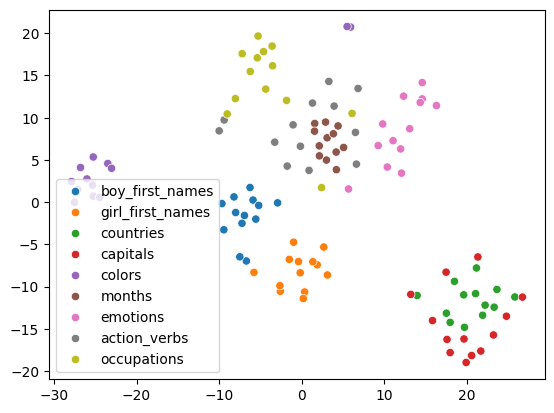

In [68]:
tsne = TSNE(n_components=2, perplexity=10)
X = SS.fit_transform(embedding_np)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=embedding_classes)

<Axes: >

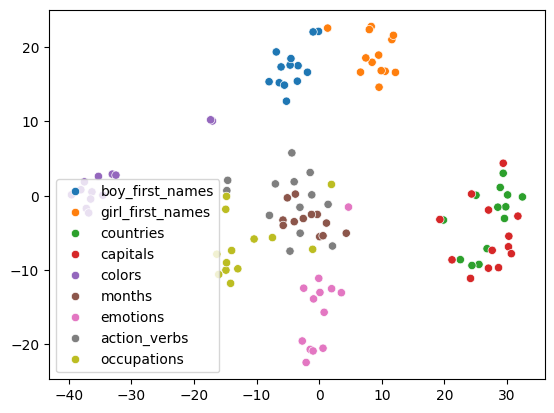

In [69]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=1)
X = SS.fit_transform(embedding_np)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=embedding_classes)

In [70]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=1, early_exaggeration=20)
components_tsne = tsne.fit_transform(X)

fig = px.scatter_3d(
    components_tsne, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)
fig.show()

### With umap

In [71]:
import umap

In [72]:
um = umap.UMAP()
X_fit = um.fit(X)           # we'll use X_fit later
X_umap = um.transform(X)


/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



<Axes: >

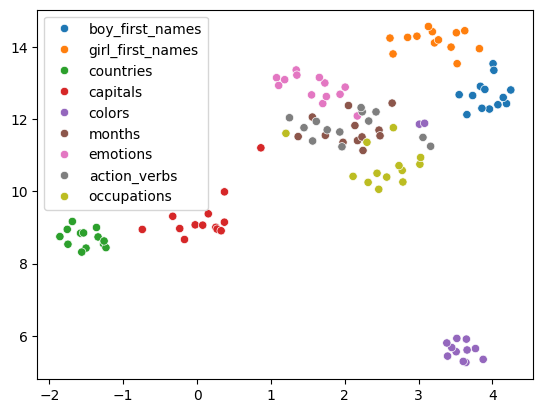

In [73]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=embedding_classes)

In [74]:
um = umap.UMAP(n_components=3)
components_umap = um.fit_transform(X)
fig = px.scatter_3d(
    components_umap, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)
fig.show()

/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [94]:
from umap import plot

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature



/Users/john/venv/ctm/lib/python3.12/site-packages/datashader/transfer_functions/__init__.py:340: RuntimeWarning:

invalid value encountered in divide



<Axes: >

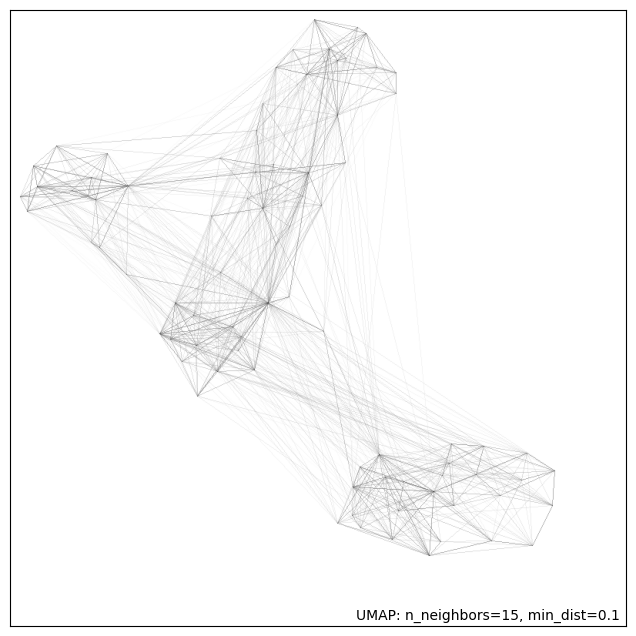

In [96]:
plot.connectivity(X_fit, show_points=True)

## Work on next layers

In [74]:
insp.tokenizer.add_bos_token

True

In [36]:
tokens, classes = [], []
for cat, wl in word_lists.items():
    we = {}
    for w in wl:
        _tok = insp.tokenizer.encode(f' {w}', return_tensors="pt").to(device)[:,-1:]
        if len(_emb.shape) > 1:
            print(w, _emb.shape)
            continue
        tokens.append(_tok)
        classes.append((cat, w))

tokens = torch.concat(tokens)
print(f"{tokens.shape=}")

tokens.shape=torch.Size([116, 1])


In [78]:
import re
names = []
for n, _ in insp.model.named_modules():
    names.append(n)

In [37]:
name_regex = r"model.language_model.layers.\d+$"
name_pattern = r"model.lanuage_model.layers.{layer_idx}"
insp.add(op.GetOutput(), name_regex=name_regex)

Added to layer ['model.language_model.layers.0', 'model.language_model.layers.1', 'model.language_model.layers.2', 'model.language_model.layers.3', 'model.language_model.layers.4', 'model.language_model.layers.5', 'model.language_model.layers.6', 'model.language_model.layers.7', 'model.language_model.layers.8', 'model.language_model.layers.9', 'model.language_model.layers.10', 'model.language_model.layers.11', 'model.language_model.layers.12', 'model.language_model.layers.13', 'model.language_model.layers.14', 'model.language_model.layers.15', 'model.language_model.layers.16', 'model.language_model.layers.17', 'model.language_model.layers.18', 'model.language_model.layers.19', 'model.language_model.layers.20', 'model.language_model.layers.21', 'model.language_model.layers.22', 'model.language_model.layers.23', 'model.language_model.layers.24', 'model.language_model.layers.25', 'model.language_model.layers.26', 'model.language_model.layers.27', 'model.language_model.layers.28', 'model.l

In [47]:
with insp.ctx(detach_state=True) as state:
    out = insp.model(tokens)

In [53]:
state['output']['model.language_model.layers.0'][0].shape

torch.Size([116, 1, 5376])

In [61]:
layer0 = state['output']['model.language_model.layers.61'][0].squeeze().cpu().numpy()

In [62]:
SS = StandardScaler()
wlayer0 = SS.fit_transform(layer0)
wlayer0.shape

(116, 5376)

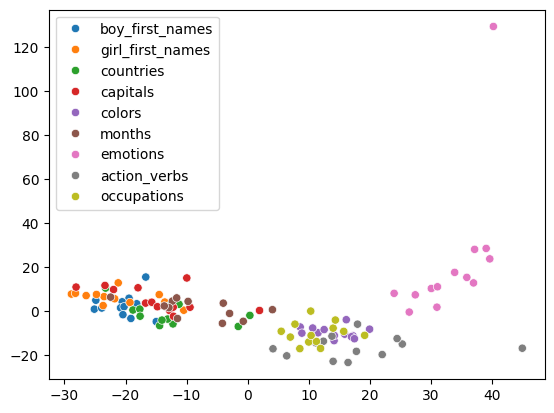

In [63]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(wlayer0)
fig2 = sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=embedding_classes)

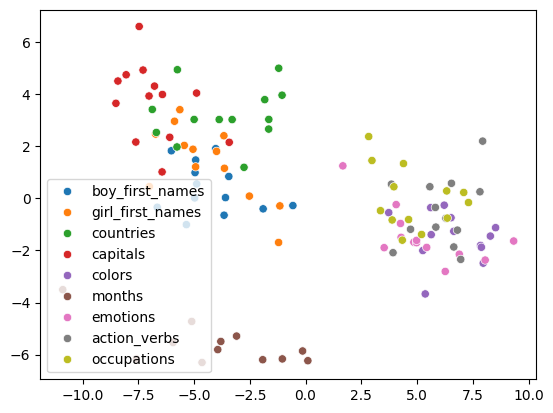

In [64]:
pca2 = PCA(n_components=2)
X_pca2 = pca.transform(wlayer0)
fig2 = sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=embedding_classes)

## When there are context

The extra context can be in the form:

- subjective - noun
- qualifier - adjective: blue, dark blue, light blue
- multi-semantic word in different contexts
- different forms of verb (e.g. did, done, doing, does)
- use of words in different scenarios: code, poem, math, reasoning...
- different by token representation: e.g blue (single token) vs b-l-u-e (4 separate tokens)

In [5]:
insp.tokenizer.encode(" dark blue")

[3223, 4171]

In [19]:
insp.tokenizer.encode(" light blue")

[2, 2214, 3730]

In [20]:
insp.tokenizer.encode(" blue")

[2, 3730]

In [6]:
"""Visualize model computational manifold"""
import re

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from dawnet.op import GetOutput


class ManifoldExperiment:
  def __init__(self, insp, words, ndim=2):
    self.insp = insp
    self.words = words
    self.ndim = ndim
    self.tokens, self.classes = self.prepare_tokens()
    self.pcas, self.names = {}, []
    self.get_op = None
    self.embed_name = None

  def prepare_tokens(self):
    try:
      add_bos_token = self.insp.tokenizer.add_bos_token
    except:
      add_bos_token = False

    tokens, classes = [], []
    for cat, wl in self.words.items():
      we = {}
      for w in wl:
        _tok = self.insp.tokenizer.encode(f' {w}', return_tensors="pt").to(self.insp.model.device)
        if add_bos_token:
          _tok = _tok[:, -1:]
        _tok = _tok[0]
        if len(_tok) > 1:
          print(w, _tok.shape)
          continue
        tokens.append(_tok)
        classes.append((cat, w))

    tokens = torch.stack(tokens)
    print(f"Constructed tokens: {tokens.shape=}")
    return tokens, classes  # len(classes) == tokens.shape[0]

  def collect(self, embed_name=None, layers=None):
    # build the embedding and create pca for the embedding
    if embed_name is None:
      candidates = []
      for n, _ in self.insp.model.named_modules():
        if "embed" in n:
          candidates.append(n)
      if len(candidates) != 1:
        raise ValueError(
          f"Cannot determine the name of the embedding module {candidates}. "
          "Please supply"
        )
      embed_name = candidates[0]

    self.embed_name = embed_name

    if layers is None:
      layers = []
      for n, _ in self.insp.model.named_modules():
        if re.match(r".*layers.\d+$", n):
          layers.append(n)

    self.names = [embed_name] + layers

    if self.get_op is not None:
      self.insp.remove(self.get_op)
    self.get_op = self.insp.add(GetOutput(), name=self.names)
    with self.insp.ctx(detach_state=True) as state:
      out = self.insp.model(self.tokens)

    result = {}
    for name in self.names:
      if name not in state['output']:
        continue

      if isinstance(state['output'][name], tuple):
        # usually the 1st item is the main output
        tensor = state['output'][name][0]
      elif isinstance(state['output'][name], torch.Tensor):
        tensor = state['output'][name]
      else:
        print(f"Unknown type for {name}: {type(state['output']['name'])}")
        continue

      result[name] = tensor.squeeze().float().cpu().numpy()

    self.pcas = result
    del state
    return out

  def show_notebook(self, figsize=None):

    cols = min(3, len(self.pcas))
    rows = (len(self.pcas) + cols - 1) // cols
    classes = [i[0] for i in self.classes]

    if figsize is None:
      figsize = (5 * cols, 4 * rows)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    x = self.pcas[self.embed_name]
    # here, each layer will have a different scaler (might not be appropriate to
    # visualize across layers) because it will not be of the same language
    # but we can't expect representation in different layers to share the same scale
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    pca = PCA(n_components=self.ndim)
    x_pca = pca.fit_transform(x_scaled)

    sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=classes, ax=axes[0])
    axes[0].set_title(self.embed_name)

    for idx, n in enumerate(self.pcas.keys()):
      if n == self.embed_name:
        continue

      x = self.pcas[n]

      scaler = StandardScaler()
      x_scaled = scaler.fit_transform(x)
      pca = PCA(n_components=self.ndim)
      x_pca = pca.fit_transform(x_scaled)
      # x_scaled = scaler.transform(x)
      # x_pca = pca.transform(x_scaled)
      markers = ["^" for _ in range(10)] + ["o" for _ in range(10, len(classes))]
      sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=classes, style=markers, ax=axes[idx])
      axes[idx].set_title(n)
      break

    fig.tight_layout()
    return fig

  def process_special_phrase(self):
    # attach special phrase -> create a phrase object
    pass


In [59]:
# %load ../dawnet/diagnose/vis_transformer_manifold.py
"""Visualize model computational manifold"""
import re
from typing import Literal

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from dawnet.op import GetOutput


class ManifoldExperiment:
  def __init__(self, insp, ndim=2):
    self.insp = insp
    self.ndim = ndim
    self.get_op = None
    self.embed_name = None

    self._add_bos_token = False
    if hasattr(self.insp.tokenizer, "add_bos_token"):
      self._add_bos_token = self.insp.tokenizer.add_bos_token

    # raw columns -> might treat this as sqlite to manage relationship
    self.phrases, self.raw_pos, self.labels, self.styles, self.skip_add_bos = [], [], [], [], []

    # processed from insp
    self.tokens, self.pos = [], []  # depend on insp model
    self.acts, self.names = {}, []

    # coordinates for visualization
    self.pcas = {}
    self.wlabels, self.wstyles = [], []

  def add_phrase(
   self, phrase: str, pos: str | Literal[-1, 0]=-1, label="default", style="o", skip_add_bos=True,
  ):
    """Construct the phrase

    Args:
      phrase: the phrase to track
      pos: If str, this is the str in `phrase` that mark the token to track; if -1
        track the last token; if 0, track all token
      label: the str label for the phrase, will determine the vis color in scatter plot
      style: will determine vis shape in scatter plot
    """
    self.phrases.append(phrase)
    self.raw_pos.append(pos)
    self.labels.append(label)
    self.styles.append(style)
    self.skip_add_bos.append(self._add_bos_token and skip_add_bos)

    if isinstance(pos, str):
      str_idx, token_idx = [], []
      idx = phrase.index(pos)
      while idx != -1:
        str_idx.append(idx)
        phrase = phrase[:idx] + phrase[idx+len(pos):]
        idx = phrase.index(pos)
      if not str_idx:
        raise ValueError(f"Cannot find pattern {pos} in phrase {phrase}")

      tokenized = self.insp.tokenizer.tokenize(phrase)
      cidx = 0
      for idx, tok in enumerate(tokenized):
        if not str_idx:
          break
        cidx += len(tok)
        if cidx > str_idx[0]:
          if self._add_bos_token:
            token_idx.append(idx+1)
          else:
            token_idx.append(idx)
          str_idx = str_idx[1:]
      self.tokens.append(self.insp.tokenizer.encode(phrase))
      self.pos.append(token_idx)
    else:
      tokens = self.insp.tokenizer.encode(phrase)
      self.tokens.append(tokens)
      if pos == -1:
        self.pos.append([-1,])
      else:
        if self._add_bos_token:
          self.pos.append(list(range(1, len(tokens)+1)))
        else:
          self.pos.append(list(range(len(tokens))))

  def collect_activations(self, embed_name=None, layers=None):
    """Build the coordinates to visualize

    Output:
      - PCA coordinate for each layer
      - X_transformed for each layer
    """
    if embed_name is None:
      candidates = []
      for n, _ in self.insp.model.named_modules():
        if "embed" in n:
          candidates.append(n)
      if len(candidates) != 1:
        raise ValueError(
          f"Cannot determine the name of the embedding module {candidates}. "
          "Please supply"
        )
      embed_name = candidates[0]

    self.embed_name = embed_name

    if layers is None:
      layers = []
      for n, _ in self.insp.model.named_modules():
        if re.match(r".*layers.\d+$", n):
          layers.append(n)

    names = [embed_name] + layers

    if self.get_op is not None:
      self.insp.remove(self.get_op)
    self.get_op = self.insp.add(GetOutput(), name=names)
    with self.insp.ctx() as state:
      acts = {n: [] for n in names}
      for idx, phrase in enumerate(self.phrases):
        token = self.insp.tokenizer.encode(phrase, return_tensors="pt").to(
          self.insp.device
        )
        if self.skip_add_bos[idx]:
          token = token[:,1:]
        _ = self.insp.model(token)

        for name in names:
          if name not in state['output']:
            continue

          if isinstance(state['output'][name], tuple):
            # usually the 1st item is the main output
            tensor = state['output'][name][0]
          elif isinstance(state['output'][name], torch.Tensor):
            tensor = state['output'][name]
          else:
            print(f"Unknown type for {name}: {type(state['output']['name'])}")
            continue

          # batch has shape b x t x d -> t x d
          act = tensor[0,self.pos[idx],:].cpu().float().numpy()
          acts[name].append(act)

    # might be inefficient if we have lots of words, but let's refactor for
    # efficiency when we need, for crude research this is good enough
    self.acts, self.names = {}, []
    for k in names:
      v = acts[k]
      if not v:
        continue
      self.acts[k] = np.concatenate(v, axis=0)
      self.names.append(k)

    # construct self.wlabels, self.wstyles
    v = self.acts[self.names[0]]
    for idx in range(len(self.phrases)):
      self.wlabels += [self.labels[idx]] * len(self.pos[idx])
      self.wstyles += [self.styles[idx]] * len(self.pos[idx])

    # TODO: free CUDA, RAM memory, save the acts to disk if necessary then treat it
    # as memmap
    return

  def build_coordinates(self, coord_system=None):
    """Build the coordinate system

    Args:
      coord_system: name of the layer that will be treated as coordinate system to
        transform the activation. If not provided, each layer construct its own
        coordinate system.
    """
    systems = self.names if coord_system is None else [coord_system]
    for s in systems:
      scaler = StandardScaler()
      x_scaled = scaler.fit_transform(self.acts[s])
      pca = PCA(n_components=self.ndim)
      pca.fit(x_scaled)
      self.pcas[s] = (scaler, pca)

  def show_notebook(self, coord_system=None):
    """Visualize in a notebook"""
    cols = min(3, len(self.acts))
    rows = (len(self.acts) + cols - 1) // cols
    figsize = (5 * cols, 4 * rows)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, name in enumerate(self.names):
      system = name if coord_system is None else coord_system
      if system not in self.pcas:
        self.build_coordinates(system)
      scaler, pca = self.pcas[system]
      x_scaled = scaler.transform(self.acts[name])
      x_pca = pca.transform(x_scaled)
      sns.scatterplot(
        x=x_pca[:,0], y=x_pca[:,1], hue=self.wlabels, style=self.wstyles, ax=axes[idx]
      )
      axes[idx].set_title(name)

    fig.tight_layout()
    return fig

  def show_notebook_old(self, figsize=None):

    cols = min(3, len(self.acts))
    rows = (len(self.acts) + cols - 1) // cols
    classes = [i[0] for i in self.classes]

    if figsize is None:
      figsize = (5 * cols, 4 * rows)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    x = self.acts[self.embed_name]
    # here, each layer will have a different scaler (might not be appropriate to
    # visualize across layers) because it will not be of the same language
    # but we can't expect representation in different layers to share the same scale
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    pca = PCA(n_components=self.ndim)
    x_pca = pca.fit_transform(x_scaled)

    sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=classes, ax=axes[0])
    axes[0].set_title(self.embed_name)

    for idx, n in enumerate(self.acts.keys()):
      if n == self.embed_name:
        continue

      x = self.acts[n]

      scaler = StandardScaler()
      x_scaled = scaler.fit_transform(x)
      pca = PCA(n_components=self.ndim)
      x_pca = pca.fit_transform(x_scaled)
      #x_scaled = scaler.transform(x)
      # x_pca = pca.transform(x_scaled)
      sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=classes, ax=axes[idx])
      axes[idx].set_title(n)

    fig.tight_layout()
    return fig

  def process_special_phrase(self):
    # attach special phrase -> create a phrase object
    pass

  def save(self, path):
    ...

  @classmethod
  def load(cls, path):
    ...

# vim: ts=2 sts=2 sw=2 et


In [60]:
exp = ManifoldExperiment(insp)
for _c, _w in word_lists.items():
    for _e in _w:
        exp.add_phrase(_e, label=_c)

exp.collect_activations(embed_name="transformer.wte", layers=insp.get_layers(name_regex=r"^transformer.h.\d+$"))
exp.build_coordinates()

Added to layer ['transformer.wte', 'transformer.h.0', 'transformer.h.1', 'transformer.h.2', 'transformer.h.3', 'transformer.h.4', 'transformer.h.5', 'transformer.h.6', 'transformer.h.7', 'transformer.h.8', 'transformer.h.9', 'transformer.h.10', 'transformer.h.11']


In [ ]:
fig = exp.show_notebook(coord_system="transformer.h.4")

In [ ]:
exp.show_notebook(coord_system="transformer.wte")

In [18]:
result = exp.collect(embed_name="transformer.wte", layers=insp.get_layers(name_regex=r"^transformer.h.\d+$"))

Added to layer ['transformer.wte', 'transformer.h.0', 'transformer.h.1', 'transformer.h.2', 'transformer.h.3', 'transformer.h.4', 'transformer.h.5', 'transformer.h.6', 'transformer.h.7', 'transformer.h.8', 'transformer.h.9', 'transformer.h.10', 'transformer.h.11']


In [ ]:
# gemma3-27b
fig = exp.show_notebook()

In [26]:
fig.savefig("gemma3-27b-embeddings.png")